# -----Reading XML

In [3]:
import xml.etree.ElementTree as ET

In [4]:
tree = ET.parse(r'C:\Users\cid2r\Documents\!VSCode\discogs_20220201_masters.xml')
#tree = ET.parse('rel.xml')
root = tree.getroot()

# ----Data Scraping

In [5]:
#pip install python3-discogs-client

In [6]:
import discogs_client

d = discogs_client.Client('ExampleApplication/0.1', user_token = 'WkcTWMWNFmwUFYHrtQIreHRnLmyFZTNnkflNHsgc')


In [7]:
import os
import urllib.request
from ast import literal_eval

def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise


macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
win_dir = r"D:\AlbumCover"


In [ ]:
#0310추가
import requests
import shutil
#0312추가
import requests
from bs4 import BeautifulSoup
import json



for release in root.iter('master'):
    id = release.attrib.get('id')
    
    if int(id) > 1900000:


        master_scarp = 'https://www.discogs.com/master/' + str(id)
        soup = BeautifulSoup(requests.get(master_scarp).text)
        rslt = soup.find('script', attrs={'id':'master_schema'})
        if rslt == None:
            continue
        else:
            json_file = json.loads(rslt.get_text())
            rating = json_file['@graph'][0]['aggregateRating']['ratingCount']
            
        standard = 1000 if 'Electronic' in literal_eval(str(json_file['@graph'][0]['genre'])) \
            or 'Rock' in literal_eval(str(json_file['@graph'][0]['genre'])) \
            else 150
    
        if rating >= standard:
            
            print(id)
    
            gens=[]
            for gen in release.iter('genre'):
               gens.append(gen.text)
    
            imglnk = d.master(id).images
            if(imglnk != None):
                if('uri150' in imglnk[0]):
                    uri = imglnk[0]['uri150']
    
        
            if len(gens) == 1:
                if gens[0] == 'Funk / Soul':
                    gens[0] = 'Funk&Soul'
                makedirs(os.path.join(win_dir, gens[0]))
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, ('Funk&Soul' if gens[0] == 'Funk / Soul' else gens[0]), img_name)
                #0310add
                makedirs(os.path.join(win_dir, gens[0]))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'})
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
            else:
                multi_dir = ''
                separator = '+'
                for idx, val in enumerate(gens):
                    multi_dir += ('Funk&Soul' if val == 'Funk / Soul' else val) + ('' if idx == len(gens) -1 else separator)
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, 'multi', multi_dir, img_name)
            
                makedirs(os.path.join(win_dir, 'multi',multi_dir))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'})
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
            
            

    
        if int(id) >= 1949999:
            break

print("done! done!")



# ----- img to CSV

In [ ]:
import os
import pandas as pd
import cv2
from deepface import DeepFace

#df 생성
album_data = pd.DataFrame(columns=['master_release', 'path','is_multi_labeled', \
    'histo_grey', 'histo_rgb', \
        'age', 'gender', 'race', 'dominant_race', 'emotion', 'dominant_emotion'])


win_dir = r"D:\AlbumCover"
macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
#경로 복사
read_path = win_dir

#장르별 열 생성
for dir in os.listdir(read_path):
    if dir == '.DS_Store':
        continue
    if dir == 'multi':
        continue
    album_data[dir] = 0


#경로 내 폴더 읽어들이기
for dir in os.listdir(read_path):
    
    if dir == 'multi' or dir == '.DS_Store':
        continue
    
    img_files = os.listdir(os.path.join(read_path, dir));
    if dir == '.DS_Store':
        continue
    #파일명을 읽어들이고 이를 dataframe에 넣기
    for img_file in img_files:
        if img_file == '.DS_Store':
            continue
        img_path = os.path.join(os.path.join(dir, img_file))
        img_info = cv2.imread(os.path.join(read_path, img_path), 0)
        
        #check whether there's a face in the album cover
        try:
            obj = DeepFace.analyze(img_path=os.path.join(read_path, img_path), actions = ['age', 'gender', 'race', 'emotion'])
        except ValueError:
            obj = None
        finally:
            if obj is not None:
                print('single yes')
                album_data = album_data.append({'master_release' : img_file[:-5],
                                                'path' : img_path,
                                                'is_multi_labeled' : False,
                                                'histo_grey' : cv2.calcHist([img_info], [0], None, [256], [0,256],),
                                                dir:1,
                                                'age' : obj['age'],
                                                'gender' : obj['gender'],
                                                'race' : str(obj['race']),
                                                'dominant_race' : obj['dominant_race'],
                                                'emotion' : str(obj['emotion']),
                                                'dominant_emotion' : obj['dominant_emotion']
                                                }, ignore_index=True)
            else:
                album_data = album_data.append({'master_release' : img_file[:-5],
                                                'path' : img_path,
                                                'is_multi_labeled' : False,
                                                'histo_grey' : cv2.calcHist([img_info], [0], None, [256], [0,256],),
                                                dir:1,
                                                }, ignore_index=True)


    

#Now adding multi genre album data

multi_path =  os.path.join(read_path, 'multi')

#each folders
for multi_gens in os.listdir(multi_path):
    if multi_gens == '.DS_Store':
        continue
    #each songs
    for multi_gen_songs in os.listdir(os.path.join(multi_path, multi_gens)):
        if multi_gen_songs == '.DS_Store':
            continue
        #make imsi dataframe but no genre info
        img_path = os.path.join(multi_path, multi_gens, multi_gen_songs)
        img_info = cv2.imread(img_path, 0)
        imsi_df = pd.DataFrame(columns=['master_release', 'path','is_multi_labeled', \
                                        'histo_grey', 'histo_rgb', \
                                        ])
        print(multi_gen_songs)
        imsi_df = imsi_df.append({'master_release' : multi_gen_songs[:-5],
                                        'path' : os.path.join('multi', multi_gens, multi_gen_songs),
                                        'is_multi_labeled' : True,
                                        'histo_grey' : cv2.calcHist([img_info], [0], None, [256], [0,256])},
                                        ignore_index=True)
        
        try:
            obj = DeepFace.analyze(img_path=img_path, actions = ['age', 'gender', 'race', 'emotion'])
        except ValueError:
            obj = None
        finally:
        #adding genre info
            for gen in multi_gens.split('+'):
                imsi_df[gen] = 1
            
            if obj is not None:
                print('multi yes')
                for data in obj:
                    if data is not 'region':
                        imsi_df[data] = str(obj[data])


            #adding imsi_df into album_data
            album_data = album_data.append(imsi_df, ignore_index=True)



album_data = album_data.fillna(0)

pd.DataFrame.to_csv(album_data, 'album_data.csv')

album_data.tail(20)



# CSV to df

In [1]:
import pandas as pd

df0415 = pd.read_csv('album_data_0415.csv')
imsi = df0415.copy()


In [ ]:
imsi


In [2]:
pd.crosstab(imsi.Jazz, imsi.Electronic)

Electronic,0.0,1.0
Jazz,,
0.0,8307,923
1.0,2605,23


# Refining Data

# How to make multi label to label???


# categorical dataframe to one-hot

In [141]:
LABEL_COLUMN = 'Something' #여기에 라벨이 될 열 이름 넣기

In [142]:
import tensorflow as tf

def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  return dataset

In [143]:
CSV_COLUMNS = ['Hip Hop', 'dominant_race', 'dominant_emotion', 'gender']

trainn = get_dataset('onlyface.csv')

In [144]:
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

In [145]:
show_batch(trainn)

gender              : [b'Man' b'Man' b'Woman' b'Man' b'Man']
dominant_race       : [b'black' b'black' b'white' b'middle eastern' b'black']
dominant_emotion    : [b'sad' b'neutral' b'happy' b'sad' b'sad']


In [146]:
CATEGORIES = {
    'gender' : ['Man', 'Woman'],
    'dominant_race' : ['white', 'black', 'asian', 'indian', 'middle eastern', 'latino hispanic'],
    'dominant_emotion' : ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
}

In [147]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
  categorical_columns.append(tf.feature_column.indicator_column(cat_col))

In [148]:
example_batch, labels_batch = next(iter(trainn))

In [150]:
categorical_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='gender', vocabulary_list=('Man', 'Woman'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='dominant_race', vocabulary_list=('white', 'black', 'asian', 'indian', 'middle eastern', 'latino hispanic'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='dominant_emotion', vocabulary_list=('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [151]:
categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(example_batch).numpy()[0])

[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]


In [152]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns)

In [153]:
print(preprocessing_layer(example_batch).numpy()[0])

[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]


# Spliting Train/Valid/Test 8/1/1

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_imsi, y_train, y_imsi = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
x_valid, x_test, y_valid, y_test = train_test_split(
    x_imsi,
    y_imsi,
    test_size=0.5,
    random_state=42
)

# Modeling w/ BP-MLL & Exact Match Rate
+ model.compile(loss=bp_mll_loss,... metrics=[Log loss]
+ model.compile(loss=RAkEL,... metrics=[hamming loss])

In [ ]:
#bpmll
from bpmll import bp_mll_loss

#exact match rate
#변경예정
def emr(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.all(y_true == y_pred, axis = 1) # axis = 1 will check for equality along rows.
    exact_match_count = np.sum(row_indicators)
    return exact_match_count/n

In [160]:
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  #...
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy', emr])

In [189]:
train_data = trainn

In [190]:
model.fit(train_data, epochs=20)

Epoch 1/20
51/51 [==============================] - 1s 11ms/step - loss: 0.5664 - accuracy: 0.7063
Epoch 2/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5652 - accuracy: 0.7063
Epoch 3/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5629 - accuracy: 0.7063
Epoch 4/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5611 - accuracy: 0.7143
Epoch 5/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5594 - accuracy: 0.7143
Epoch 6/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5578 - accuracy: 0.7143
Epoch 7/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5557 - accuracy: 0.7143
Epoch 8/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5546 - accuracy: 0.7143
Epoch 9/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5520 - accuracy: 0.7143
Epoch 10/20
51/51 [==============================] - 0s 9ms/step - loss: 0.5519 - accuracy: 0.7143
Epoch 11/20
51/51 

In [191]:
loss, accu = model.evaluate(trainn)

51/51 [==============================] - 0s 8ms/step - loss: 0.5376 - accuracy: 0.7183


In [197]:
predictions = model.predict(trainn)


for i in predictions:
    if i > 0.4:
        print('hip')
    else:
        print('no')

no
hip
hip
hip
no
hip
hip
hip
no
hip
no
no
no
no
hip
hip
no
hip
no
no
no
no
no
hip
hip
no
no
no
hip
hip
hip
no
no
hip
no
hip
no
hip
hip
no
hip
no
no
hip
hip
no
no
no
no
hip
no
hip
no
hip
no
no
hip
no
no
no
hip
hip
no
no
no
no
hip
no
no
no
hip
no
no
no
hip
no
hip
no
no
hip
hip
hip
hip
no
hip
hip
no
no
no
hip
hip
hip
no
no
hip
no
no
no
no
hip
no
no
hip
no
hip
no
hip
no
hip
no
no
no
hip
no
no
hip
no
hip
hip
hip
no
no
no
no
no
hip
no
no
no
no
hip
no
hip
hip
no
hip
hip
hip
no
hip
no
hip
no
hip
no
no
hip
hip
no
no
no
hip
hip
hip
no
no
no
hip
no
no
hip
hip
no
hip
hip
no
hip
hip
no
hip
hip
hip
hip
hip
no
no
no
hip
no
no
hip
no
hip
hip
hip
hip
no
hip
hip
no
no
no
hip
no
hip
hip
hip
hip
hip
no
hip
no
no
no
hip
hip
hip
hip
no
no
hip
no
hip
no
hip
hip
hip
no
hip
no
hip
hip
hip
no
hip
hip
no
hip
hip
hip
hip
no
hip
no
hip
no
hip
no
no
hip
hip
no
no
hip
hip
no
hip
hip
no
no
no
hip


In [ ]:
'''
import os

#win
#db_list = os.listdir(r"C:\Users\cid2r\Documents\!VSCode\0220dbtest\data")

#mac
db_list = os.listdir(r"/Users/cooky/Documents/GitHub/0220dbtest/data")
'''

In [ ]:
'''
import pandas as pd


alldata = []

for file in db_list:
    df = pd.read_csv(file)
    alldata.append(df)

df_0_2_100k = pd.concat(alldata, axis=0, ignore_index=True)
df_0_2_100k.to_csv("/Users/cooky/Documents/GitHub/0220dbtest/data/output", index=False)

'''


In [ ]:
df_0_2_100k = pd.read_csv("data_20k_2_25k.csv")

df_test = df_0_2_100k.copy()
df_test.drop(columns='Unnamed: 0')

In [ ]:
from ast import literal_eval


for idx,row in df_test.iterrows():
    gen_str = row['genre']
    gens = literal_eval(gen_str)
    #print(idx)
    for gen in gens:
        if gen in df_test.columns:
            df_test.at[idx, gen] = 1
        else:
            df_test[gen] = 0
            df_test.at[idx, gen] = 1

            

            

In [ ]:
pd.crosstab(df_test.Jazz, df_test.Electronic)

In [ ]:
DISCOGS_KEY = 'OKxXReJmUJvMJRRsaOqr'
DISCOGS_SECRET = 'RormADbxpiujDCXDiBDwFGUFxKrVjkTK'

----실험실

In [3]:
import torch

torch.cuda.is_available()

True

In [51]:
#win
#pip install fastai

#mac
! conda install -c fastai fastai

^C


In [86]:

macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/img/"
win_dir = r"D:\AlbumCover"

BATCH_SIZE = 32
IMG_HEI = 150
IMG_WID = 150

In [87]:
import pathlib

dat_dir = pathlib.Path(win_dir)
cnt = len(list(dat_dir.glob('*/*.jpeg')))
print(cnt)

8428


In [88]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image




In [44]:
print(tf.__version__)

2.8.0


In [89]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dat_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEI, IMG_WID),
    batch_size=BATCH_SIZE
)

Found 8428 files belonging to 13 classes.
Using 6743 files for training.


In [90]:
lb = np.concatenate([y for x, y in train_ds], axis = 0)


In [91]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEI, IMG_WID),
  batch_size=BATCH_SIZE)

Found 8428 files belonging to 13 classes.
Using 1685 files for validation.


In [92]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=211>

In [78]:
class_names = train_ds.class_names
print(class_names)

['Blues', 'Classical', 'Electronic', 'Folk, World, & Country', 'Funk&Soul', 'Hip Hop', 'Jazz', 'Latin', 'Non-Music', 'Pop', 'Reggae', 'Rock', 'Stage & Screen']


In [81]:
def wcount(num):
    return (1 / num) * (8428/13)

In [82]:
class_weight = {
    0 : wcount(167),
    1 : wcount(103),
    2 : wcount(476),
    3 : wcount(277),
    4 : wcount(1784),
    5 : wcount(1539),
    6 : wcount(1514),
    7 : wcount(44),
    8 : wcount(33),
    9 : wcount(448),
    10 : wcount(363),
    11 : wcount(1605),
    12 : wcount(75)
}

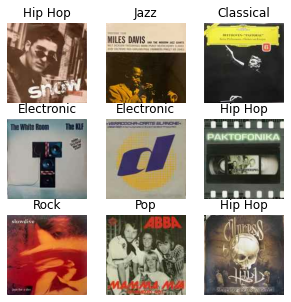

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [94]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 150, 150, 3)
(32,)


In [95]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [96]:
lb = np.concatenate([y for x, y in train_ds], axis = 0)

In [97]:
from tensorflow.keras import layers

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [98]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [50]:
num_classes = 13

model = Sequential([
  layers.Conv2D(224, 64, padding='same', activation='relu',input_shape=(IMG_HEI, IMG_WID, 3)),
  #layers.Conv2D(224, 64, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(112, 128, padding='same', activation='relu'),
  #layers.Conv2D(112, 128, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(56, 256, padding='same', activation='relu'),
  layers.Conv2D(56, 256, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

ResourceExhaustedError: OOM when allocating tensor with shape[256,256,224,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [33]:
model.compile(optimizer='sgd', loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs =10


with tf.device("/device:GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEI, 
                                                              IMG_WID,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [118]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight(
    'balanced',np.unique(train_ds.class_names)
    ,train_ds.class_names
)

print(class_weight)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


C:\Users\cid2r\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['Blues' 'Classical' 'Electronic' 'Folk, World, & Country' 'Funk&Soul'
 'Hip Hop' 'Jazz' 'Latin' 'Non-Music' 'Pop' 'Reggae' 'Rock'
 'Stage & Screen' 'models' 'multi'], y=['Blues', 'Classical', 'Electronic', 'Folk, World, & Country', 'Funk&Soul', 'Hip Hop', 'Jazz', 'Latin', 'Non-Music', 'Pop', 'Reggae', 'Rock', 'Stage & Screen', 'models', 'multi'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [108]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

ResourceExhaustedError: OOM when allocating tensor with shape[57600,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [102]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu',),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

NameError: name 'data_augmentation' is not defined

In [246]:
from tensorflow.keras.applications.resnet50 import ResNet50

#model = ResNet50(weights='imagenet')

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
print(class_weight)

{0: 3.881621372639337, 1: 6.293502613890963, 2: 1.3618293471234648, 3: 2.34018328242155, 4: 0.3633580545015523, 5: 0.42120257909731595, 6: 0.4281577075500458, 7: 14.732517482517483, 8: 19.643356643356647, 9: 1.4469436813186813, 10: 1.785759694850604, 11: 0.40388209920920204, 12: 8.643076923076924}


In [60]:
epochs = 5

with tf.device("/device:GPU:0"):
  history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\cid2r\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\cid2r\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\cid2r\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\cid2r\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\cid2r\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\cid2r\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 224, 224, 3)


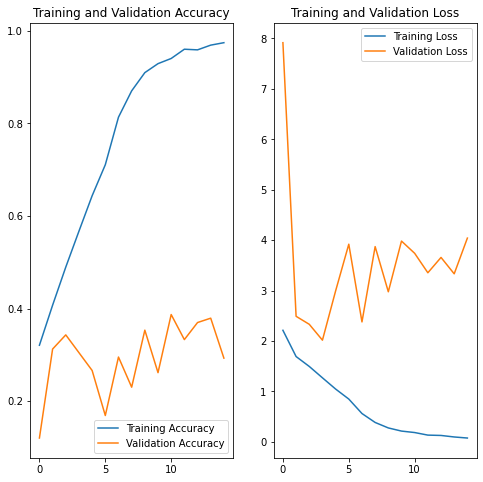

In [212]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [213]:
prob = tf.keras.Sequential([model,
                            tf.keras.layers.Softmax()])

pred = prob.predict(val_ds, verbose=2)


type(val_ds)

20/20 - 3s - 3s/epoch - 153ms/step


tensorflow.python.data.ops.dataset_ops.BatchDataset

In [214]:
y_train = np.concatenate([y for x, y in val_ds], axis = 0)


In [215]:
np.argmax(pred, axis=1)


array([ 4,  2, 10, ...,  4,  4, 10], dtype=int64)

In [216]:

#y_train = tf.data.Dataset.from_tensor_slices(list(val_ds))


confusion = tf.math.confusion_matrix(
    labels = y_train,
    predictions=np.argmax(pred, axis=1),
    num_classes=13
)

print(confusion)

tf.Tensor(
[[ 0  0  2  0  1  0  0  0  0  1  4  4  0]
 [ 0  0  3  0  2  0  2  0  0  1  2  1  0]
 [ 3  0 19  0 19  6  2  0  0  2 15 17  0]
 [ 0  0  2  0  5  0  0  0  0  0  6  5  0]
 [ 5  2 43  0 43 37 12  0  0  9 59 61  0]
 [ 3  0 42  0 46 25 12  0  0 10 78 60  0]
 [ 6  1 28  0 33 12  6  0  0  5 44 36  0]
 [ 0  0  0  0  2  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  1  1  0  0  0  0  1  0  0]
 [ 1  0  6  0 12  3  2  0  0  2 19 16  0]
 [ 0  0  6  0  9  3  1  1  0  5 12 11  0]
 [ 4  1 53  0 55 31 18  0  0  8 68 67  0]
 [ 1  0  3  0  1  1  0  0  0  0  3  2  0]], shape=(13, 13), dtype=int32)


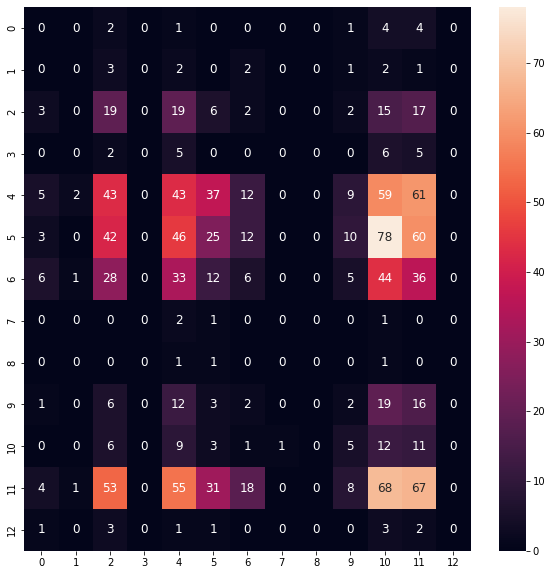

In [217]:
import seaborn as sns
import pandas as pd

cm = pd.DataFrame(confusion.numpy(),
                  range(num_classes),
                  range(num_classes))

plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={'size': 12})
plt.show()

In [140]:
for i in range(13):
    print(class_names[i])



Blues
Classical
Electronic
Folk, World, & Country
Funk&Soul
Hip Hop
Jazz
Latin
Non-Music
Pop
Reggae
Rock
Stage & Screen


In [120]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

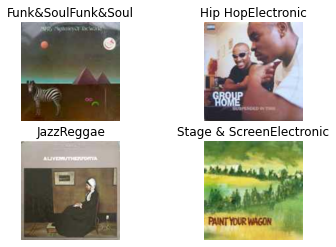

In [224]:
for images, labels in train_ds.take(1):
    for i in range(4):
        ax=plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]] + class_names[np.argmax(pred[i])]
)
        plt.axis('off')
